This script is meant for training the DQN model using the simulator.

The code has been modfied around the pytorch tutorial found here:
https://github.com/pytorch/tutorials/blob/master/intermediate_source/reinforcement_q_learning.py
    
Another good source for understanding the DQN paper can be found here:
    
https://medium.com/@awjuliani/simple-reinforcement-learning-with-tensorflow-part-4-deep-q-networks-and-beyond-8438a3e2b8df

NOTE: The code has not thoroughly been tested and there might be some bugs

In [1]:
from simulator import VirtualSegmentation
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from copy import deepcopy
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T
import pdb
import cv2
import copy

Below is just one example sample of the arena of the robot

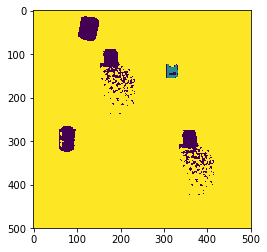

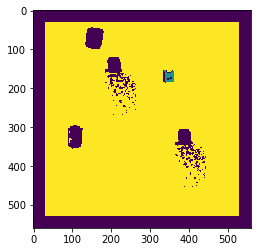

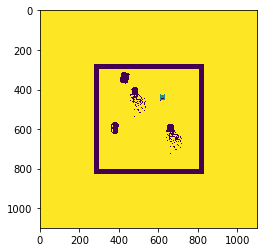

In [2]:
arena = np.load("arena.npy")

lego = arena[317:355,217:256].copy()

#lego_shape = lego.shape
arena[317:355,217:256] = 2


arena[120:120+38, 300:300+39] = lego

plt.imshow(arena)
plt.show()
arena.shape
#arena[300:400, 200:250] = 2
boundary = np.zeros((560,560))
boundary[30:530,30:530] = arena

plt.imshow(boundary)
plt.show()

environment = np.ones((1100,1100))*2
environment[270:270+560,270:270+560] = boundary

plt.imshow(environment)
plt.show()

In [3]:
# if gpu is to be used
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor


In [4]:
######################################################################
# Replay Memory
# -------------
#
# We'll be using experience replay memory for training our DQN. It stores
# the transitions that the agent observes, allowing us to reuse this data
# later. By sampling from it randomly, the transitions that build up a
# batch are decorrelated. It has been shown that this greatly stabilizes
# and improves the DQN training procedure.
#
# For this, we're going to need two classses:
#
# -  ``Transition`` - a named tuple representing a single transition in
#    our environment
# -  ``ReplayMemory`` - a cyclic buffer of bounded size that holds the
#    transitions observed recently. It also implements a ``.sample()``
#    method for selecting a random batch of transitions for training.
#

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [5]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(4)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(8)
        self.conv3 = nn.Conv2d(8, 8, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(8)
        self.head = nn.Linear(8*12*12, 3)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [6]:

resize = T.Compose([T.ToPILImage(),
                    T.Scale(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


In [7]:

BATCH_SIZE = 1024
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200

model = DQN()
target_model = DQN()

if use_cuda:
    model.cuda()
    target_model.cuda()

optimizer = optim.RMSprop(model.parameters())
memory = ReplayMemory(100000)


steps_done = 0

Uncomment the below lines if a pre-trained model is already available (e.g. from imitation)

In [8]:
model = DQN()
#pretrained_dict = torch.load("DQN_model.pth")
#network_dict = model.state_dict()
#network_dict.update(pretrained_dict)
#model.load_state_dict(pretrained_dict) 

target_model = DQN()
#pretrained_dict = torch.load("DQN_model.pth")
#network_dict = target_model.state_dict()
#network_dict.update(pretrained_dict)
#target_model.load_state_dict(pretrained_dict) 

if use_cuda:
    model.cuda()
    target_model.cuda()

In [9]:

def optimize_model():
    global last_sync
    if len(memory) < BATCH_SIZE:
        return
    #print("optimized")
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = ByteTensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)))

    # We don't want to backprop through the expected action values and volatile
    # will save us on temporarily changing the model parameters'
    # requires_grad to False!
    non_final_next_states = Variable(torch.cat([s for s in batch.next_state
                                                if s is not None]),
                                     volatile=True)
    state_batch = Variable(torch.cat(batch.state))
    action_batch = Variable(torch.cat(batch.action))
    reward_batch = Variable(torch.cat(batch.reward))

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    state_action_values = model(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = Variable(torch.zeros(BATCH_SIZE).type(Tensor))
    next_state_values[non_final_mask] = target_model(non_final_next_states).max(1)[0]
    # Now, we don't want to mess up the loss with a volatile flag, so let's
    # clear it. After this, we'll just end up with a Variable that has
    # requires_grad=False
    next_state_values.volatile = False
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [10]:
def get_state_tensor(st):
    st = cv2.resize(st, (120,120), interpolation = cv2.INTER_NEAREST)
    st = np.expand_dims(st, axis = 0)
    st = np.expand_dims(st, axis = 0)
    
    st = torch.from_numpy(st).type(Tensor)
    
    return st
    

In [11]:

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        return model(
            Variable(state, volatile=True).type(FloatTensor)).data.max(1)[1].view(1, 1)
    else:
        return LongTensor([[random.randrange(3)]])



In [12]:
def get_environment_without_obstacle():
    lego_shape = lego.shape
    arena2 = np.ones_like(arena)*2
    x = np.random.randint(40,460)
    y = np.random.randint(40,460)
    arena2[x:x+lego_shape[0],y:y+lego_shape[1]] = lego.copy()
    x = np.random.randint(40,460)
    y = np.random.randint(40,460)
    arena2[x:x+lego_shape[0],y:y+lego_shape[1]] = lego.copy()
    x = np.random.randint(40,460)
    y = np.random.randint(40,460)
    arena2[x:x+lego_shape[0],y:y+lego_shape[1]] = lego.copy()
    plt.imshow(arena2)
    plt.show()
    boundary = np.zeros((560,560))
    boundary[30:530,30:530] = arena2

    #plt.imshow(boundary)
    #plt.show()

    environment = np.ones((1100,1100))*2
    environment[270:270+560,270:270+560] = boundary

    #plt.imshow(environment)
    #plt.show()
    return environment
    

In [13]:
#env = VirtualSegmentation(get_environment_without_obstacle(),5,3)
num_episodes = 10
for i_episode in range(num_episodes):
    print(i_episode)
    #env = VirtualSegmentation(get_environment_without_obstacle(),15,3)
    env = VirtualSegmentation(environment,15,3)
    # Initialize the environment and state
    state = env.reset()
    state = get_state_tensor(state)
    env.render()
    if i_episode !=0 and i_episode%5==0:
        dictionary = model.state_dict()
        dictionary_clone = copy.deepcopy(dictionary)
        target_model.load_state_dict(dictionary_clone)

    for t in count():
        
        if t> 1000:
            break
        #print(t)
        # Select and perform an action
        action = select_action(state)
        #action = model(Variable(state, volatile=True).type(FloatTensor)).data.max(1)[1].view(1, 1)

        next_state, reward, done = env.step(action[0, 0])
        #print(reward)
        
        next_state = get_state_tensor(next_state)
        reward = Tensor([reward])
        


        if done:
            next_state = None
            print(reward, t)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            
            break

print('Complete')

0

 500
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 79
1

 500
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 45
2

 500
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 45
3

 500
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 89
4

 500
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 71
5

 500
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 116
6

 500
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 96
7

 500
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 158
8

 500
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 323
9


KeyboardInterrupt: 

In [28]:
torch.save(model.state_dict(), "DQN_model.pth")